# Analysis

After running the model against the 133 test images, only 2 where found to have failed to identify the counter region (one found the region, but it was too small to capture the full read)

000647d

<img src="./../results/testing/000647d-prediction.jpg" alt="Drawing" style="height: 300px;"/>

000668d
<img src="./../results/testing/000668d-prediction.jpg" alt="Drawing" style="height: 300px;"/>

In [14]:
from __future__ import generators

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import sys
import os
from pandas import *
from yolo_lib.darknet import *
from yolo_lib.non_maximal_suppression import *
from yolo_lib.annotation import *
import glob

def get_reading(filename):
    annotations = Annotation.create_from_file(filename)
    # todo we sort by centreX here but leftX in prediction
    annotations.sort(key=lambda annotation: annotation.centreX)
    return ("".join(map(lambda annotation: str(annotation.className), annotations)))

def get_predicted_reading(detections, overlap_threshold):
    
    predictions = list(map(lambda o: Prediction(
        o[0].decode('utf-8'), 
        o[1],
        o[2][0] - o[2][2]/2,
        o[2][1] - o[2][3]/2,
        o[2][2],
        o[2][3]
    ), detections)) 

    predictions = non_maximal_suppression(predictions, projected_overlap_coefficient, overlap_threshold) 
    predictions = predictions[:5] # take top 5 (ordered by confidence) TODO extend to variable coutner sizes
    
    # sort from left to right
    predictions.sort(key=lambda prediction: prediction.leftx)
    return str(("".join(map(lambda prediction: str(prediction.class_), predictions))))

def score(threshold = .25, overlap_threshold = .15):
    images = glob.glob( "./../ufpramir/cropped/testing/*.jpg")
    #images = images[:1]
    matches = 0
    total = 0
    for filename in images:

        base = os.path.splitext(filename)[0]
        ground_truth = base  + '.txt'
        
        actual = get_reading(ground_truth)
        results = performDetect(
            filename, 
            threshold, 
            "./../cfg/counters-yolov3-tiny.cfg", 
            "./../weights/counters-yolov3-tiny-b633ebb_best.weights", 
            "./../cfg/counters.data", 
            False, 
            False, 
            False
        )
        predictedReading = get_predicted_reading(results, overlap_threshold)
            
        if(actual == predictedReading):
            matches = matches + 1

        total =  total + 1
        
        #print('%s %s %s' %(filename, actual, predictedReading))
        
    return (matches/total)



In [15]:
print(score(.25, .15))

0.7089084065244667


![alt](./../ufpramir/cropped/testing/meter1690-cropped.jpg)

In [7]:
overlap_thresholds = list(map(lambda x: x/100, range(0, 100, 1)))
scores = list();

#for threshold in overlap_thresholds:
#    scores.append(score(.25, threshold))

#df = pd.DataFrame(zip(overlap_thresholds, scores),columns=['overlap threshold (poc)', 'accuracy'])

df = pandas.read_csv('overlap-poc-threshold-b633ebb-detection-25.csv')
df.head(10)

,overlap threshold (poc),accuracy
0,0.00,0.690088
1,0.01,0.691343
2,0.02,0.691343
3,0.03,0.691343
4,0.04,0.690088
5,0.05,0.690088
6,0.06,0.690088
7,0.07,0.690088
8,0.08,0.690088
9,0.09,0.690088


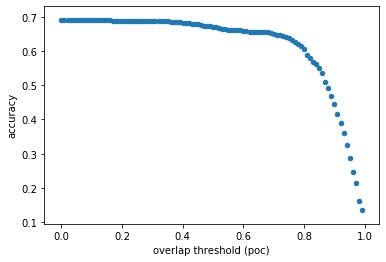

In [8]:
df.plot.scatter(x='overlap threshold (poc)', y='accuracy')

In [10]:
detection_thresholds = list(map(lambda x: x/100, range(25, 100, 1)))
scores = list();

#for threshold in detection_thresholds:
#    scores.append(score(threshold, .15))

#df2 = pd.DataFrame(zip(detection_thresholds, scores),columns=['detection threshold', 'accuracy'])
#results_file = open("results/detection-threshold-b633ebb-poc-15.csv", "w")
#results_file.write(df2.to_csv(index=False))
#results_file.close()

df2 = pandas.read_csv('detection-threshold-b633ebb-poc-15.csv')
df2.head(15)

,detection threshold,accuracy
0,0.25,0.690088
1,0.26,0.685069
2,0.27,0.685069
3,0.28,0.685069
4,0.29,0.686324
5,0.30,0.680050
6,0.31,0.678795
7,0.32,0.675031
8,0.33,0.667503
9,0.34,0.663739


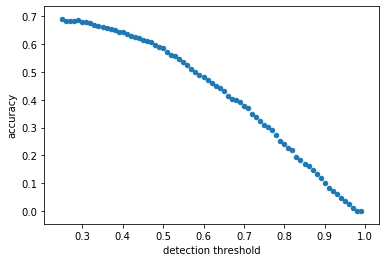

In [11]:
df2.plot.scatter(x='detection threshold', y='accuracy')